In [32]:
import pandas as pd
import os

# Directory containing the CSV files
directory = 'MSCI/'

# Initialize an empty DataFrame to hold the aggregated data
aggregate_df = pd.DataFrame()

# Loop through all the files in the specified directory
for filename in os.listdir(directory):
    
    if filename.endswith(".csv"):
        # Construct the full file path
        file_path = os.path.join(directory, filename)
        
        # Read the CSV file into a DataFrame
        temp_df = pd.read_csv(file_path)
        
        # Ensure the 'Date' column is parsed as datetime type
        temp_df['Date'] = pd.to_datetime(temp_df['Date'])
        
        # Set the 'Date' column as the index of the DataFrame
        temp_df.set_index('Date', inplace=True)
        
        # Append the data to the aggregate DataFrame
        aggregate_df = pd.concat([aggregate_df, temp_df])
        print(aggregate_df)

# Sort the DataFrame by the index (Date) in case the files were not in chronological order
aggregate_df.sort_index(inplace=True)

# Show the first few rows of the aggregate DataFrame
print(aggregate_df.head())


                 Open       High        Low      Close  Adj Close  Volume
Date                                                                     
2014-06-12  49.880001  49.950001  49.880001  49.950001  37.997379   10200
2014-06-13  49.910000  49.910000  49.849998  49.910000  37.966961    2600
2014-06-16  49.650002  49.669998  49.650002  49.669998  37.784389    1000
2014-06-17  49.380001  49.669998  49.380001  49.669998  37.784389    1500
2014-06-18  49.790001  50.430000  49.790001  50.430000  38.362526   25700
...               ...        ...        ...        ...        ...     ...
2014-12-23  44.560001  44.560001  44.230000  44.270000  33.896431   68600
2014-12-24  44.430000  44.709999  44.389999  44.529999  34.095516  153400
2014-12-26  44.770000  44.810001  44.570000  44.700001  34.225685   19800
2014-12-29  44.299999  44.520000  44.240002  44.250000  33.881130   77100
2014-12-30  44.009998  44.240002  43.889999  44.040001  33.720333  259400

[140 rows x 6 columns]
              

In [33]:
aggregate_df.to_csv('all_data_msci.csv', header=True)

In [34]:
# Plotting the High, Low, and Close prices
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


In [20]:
# Let's first load the provided datasets to examine their structure
import pandas as pd

# Load the S&P 500 historical data
sp500_data_path = 'sp500_historical_data.csv'
sp500_df = pd.read_csv(sp500_data_path)
sp500_df['DATE'] = pd.to_datetime(sp500_df['Date'])
sp500_df.set_index('DATE', inplace=True)
# Load the CPI (Consumer Price Index) data
cpi_data_path = 'CPIAUCSL.csv'
cpi_df = pd.read_csv(cpi_data_path)

cpi_df.columns
cpi_df['DATE'] = pd.to_datetime(cpi_df['DATE'])
cpi_df['YearMonth'] = cpi_df['DATE'].to_period('M')
cpi_df.set_index('DATE', inplace=True)

TypeError: unsupported Type RangeIndex

In [ ]:
cpi_df

In [19]:
import pandas as pd

# Assuming cpi_df and sp500_df are already defined and loaded

# Step 1: Calculate Monthly Inflation Rate
monthly_inflation_rate = cpi_df['CPIAUCSL'].pct_change()

# Prepare CPI data to ensure it aligns with the S&P 500 date range
cpi_df['YearMonth'] = cpi_df.index.to_period('M')

# Step 2: Match Monthly Inflation Rates with S&P 500 Data
sp500_df['YearMonth'] = sp500_df.index.to_period('M')
sp500_df = sp500_df.merge(monthly_inflation_rate.rename('InflationRate'), how='left', left_on='YearMonth', right_index=True)

# Step 3: Adjust S&P 500 'Close' Prices by Monthly Inflation Rate
# Assuming the 'Close' price needs to be adjusted downwards by the inflation rate
sp500_df['RealCloseFinal'] = sp500_df.apply(lambda row: row['Close'] * (1 + row['InflationRate']), axis=1)

# Clean up the DataFrame by removing the intermediate 'YearMonth' column
sp500_df.drop(columns=['YearMonth', 'InflationRate'], inplace=True)

# Display the adjusted DataFrame
print(sp500_df[['Close', 'RealCloseFinal']].tail())


AttributeError: 'Index' object has no attribute 'to_period'

In [37]:
# Correcting the approach to interpolate daily inflation rates and apply them
from pandas.tseries.offsets import MonthEnd

# Adjust the interpolation function to avoid the previous error
def correct_interpolate_daily_inflation_rates(monthly_rates, dates):
    daily_rates = pd.Series(index=dates, dtype=float)
    for date in dates:
        year, month = date.year, date.month
        # Find the corresponding monthly rate
        monthly_rate = monthly_rates.get((year, month))
        if pd.notna(monthly_rate):
            # Calculate daily rate assuming a constant rate across the month
            daily_rate = (1 + monthly_rate) ** (1/30) - 1
            daily_rates.loc[date] = daily_rate
    return daily_rates

# Reformat monthly_inflation_rate to use (year, month) as key for easier access
monthly_inflation_rate = monthly_inflation_rate.reset_index()
monthly_inflation_rate['YearMonth'] = monthly_inflation_rate['DATE'].dt.to_period('M')
monthly_inflation_rate.set_index('YearMonth', inplace=True)
monthly_inflation_rate = monthly_inflation_rate['CPIAUCSL']

# Interpolate daily inflation rates again, correctly this time
daily_inflation_rates_corrected = correct_interpolate_daily_inflation_rates(monthly_inflation_rate, sp500_dates)

# Apply the corrected daily inflation rates to adjust the S&P 500 'Close' prices
real_prices_corrected = sp500_df['Close'].copy()
for date in sp500_dates:
    daily_rate = daily_inflation_rates_corrected.get(date, np.nan)
    if pd.notna(daily_rate):
        real_prices_corrected.loc[date] *= (1 - daily_rate)

# Update the DataFrame with the corrected real prices
sp500_df['RealCloseCorrected'] = real_prices_corrected

# Display the first few rows to verify the adjustments
sp500_df.head()


,Open,High,Low,Close,Adj Close,Volume,RealCloseCorrected
Date,,,,,,,
2014-06-12,49.880001,49.950001,49.880001,49.950001,37.997379,10200,49.950001
2014-06-13,49.910000,49.910000,49.849998,49.910000,37.966961,2600,49.910000
2014-06-16,49.650002,49.669998,49.650002,49.669998,37.784389,1000,49.669998
2014-06-17,49.380001,49.669998,49.380001,49.669998,37.784389,1500,49.669998
2014-06-18,49.790001,50.430000,49.790001,50.430000,38.362526,25700,50.430000


In [38]:
monthly_inflation_rate

YearMonth
1947-01         NaN
1947-01    0.006518
1947-01    0.017576
1947-01    0.000000
1947-01   -0.002273
             ...   
2023-01    0.006312
2023-01    0.003957
2023-01    0.000449
2023-01    0.000969
2023-01    0.003030
Freq: M, Name: CPIAUCSL, Length: 924, dtype: float64

In [39]:
# Correcting the approach: Simplify the process to match daily dates with their corresponding monthly inflation rates

# Convert monthly inflation rate back to a simple format for easier handling
monthly_inflation_rate = cpi_df['CPIAUCSL'].pct_change()

# Calculate the monthly to daily inflation rate again, this time using a more direct approach
def simplified_daily_inflation_rates(monthly_rates, sp500_df):
    daily_rates = pd.Series(index=sp500_df.index, dtype=float)
    for month_end in monthly_rates.index:
        month_rate = monthly_rates.loc[month_end]
        if pd.notna(month_rate):
            days_in_month = daily_rates[month_end.strftime('%Y-%m')]
            daily_rate = (1 + month_rate) ** (1/len(days_in_month)) - 1
            daily_rates.loc[days_in_month.index] = daily_rate
    return daily_rates

# Get the end of month dates for the S&P 500 data frame to match with CPI data
sp500_df['YearMonth'] = sp500_df.index.to_period('M')
monthly_inflation_rate_for_sp500 = monthly_inflation_rate[monthly_inflation_rate.index.isin(sp500_df['YearMonth'].unique().to_timestamp())]

# Apply simplified daily inflation rates calculation
daily_inflation_rates_final = simplified_daily_inflation_rates(monthly_inflation_rate_for_sp500, sp500_df)

# Apply the final daily inflation rates to adjust the S&P 500 'Close' prices
sp500_df['RealCloseFinal'] = sp500_df['Close'].copy()
for date, rate in daily_inflation_rates_final.items():
    if pd.notna(rate):
        sp500_df.loc[date, 'RealCloseFinal'] =float(sp500_df.loc[date, 'Close'])*(1 - rate)

# Clean up the DataFrame by removing the intermediate 'YearMonth' column
sp500_df.drop(columns=['YearMonth'], inplace=True)

# Display the first few rows to verify the adjustments
sp500_df[['Close', 'RealCloseFinal']].tail(100)


,Close,RealCloseFinal
Date,,
2023-09-13,50.849998,50.849998
2023-09-14,51.500000,51.500000
2023-09-15,51.430000,51.430000
2023-09-18,51.040001,51.040001
2023-09-19,51.070000,51.070000
...,...,...
2024-01-30,54.889999,54.889999
2024-01-31,54.480000,54.480000
2024-02-01,55.020000,55.020000


In [40]:
sp500_df = sp500_df.rename(columns={'RealCloseFinal': 'Real Total Return Price'})

In [29]:
sp500_df.query('Date<2024')

,Open,High,Low,Close,Adj Close,Volume,RealCloseCorrected,Real Total Return Price
Date,,,,,,,,
1984-01-03,997.500000,1001.400024,997.500000,997.500000,997.500000,0,997.500000,997.364470
1984-01-04,997.500000,999.500000,993.299988,998.599976,998.599976,0,998.599976,998.464296
1984-01-05,1007.099976,1015.799988,1007.099976,1015.799988,1015.799988,0,1015.799988,1015.661971
1984-01-06,1019.000000,1029.300049,1019.000000,1029.000000,1029.000000,0,1029.000000,1028.860190
1984-01-09,1030.599976,1035.400024,1030.599976,1034.599976,1034.599976,0,1034.599976,1034.459405
...,...,...,...,...,...,...,...,...
2023-12-21,7715.700195,7715.700195,7668.399902,7694.700195,7694.700195,603350200,7694.700195,7694.700195
2023-12-22,7694.700195,7715.200195,7676.399902,7697.500000,7697.500000,329604400,7697.500000,7697.500000
2023-12-27,7697.500000,7759.700195,7697.500000,7725.000000,7725.000000,432594200,7725.000000,7725.000000


In [41]:
sp500_df = sp500_df.rename(columns={'RealCloseFinal': 'Real Total Return Price'})

In [42]:
sp500_df.to_csv('MSCI_processed.csv',header=True)

In [13]:
import pandas as pd

# Load the S&P 500 data
sp500_data = pd.read_csv('all_data.csv')

# Load the CPI data
cpi_data = pd.read_csv('CPIAUCSL.csv')

# Display the first few rows of both datasets to understand their structure
sp500_data.head(), cpi_data.head()


(         Date        Open        High         Low       Close   Adj Close  \
 0  2000-08-30  273.899994  273.899994  273.899994  273.899994  273.899994   
 1  2000-08-31  274.799988  278.299988  274.799988  278.299988  278.299988   
 2  2000-09-01  277.000000  277.000000  277.000000  277.000000  277.000000   
 3  2000-09-05  275.799988  275.799988  275.799988  275.799988  275.799988   
 4  2000-09-06  274.200012  274.200012  274.200012  274.200012  274.200012   
 
    Volume  
 0       0  
 1       0  
 2       0  
 3       2  
 4       0  ,
          DATE  CPIAUCSL
 0  01/01/1947     21.48
 1  01/02/1947     21.62
 2  01/03/1947     22.00
 3  01/04/1947     22.00
 4  01/05/1947     21.95)

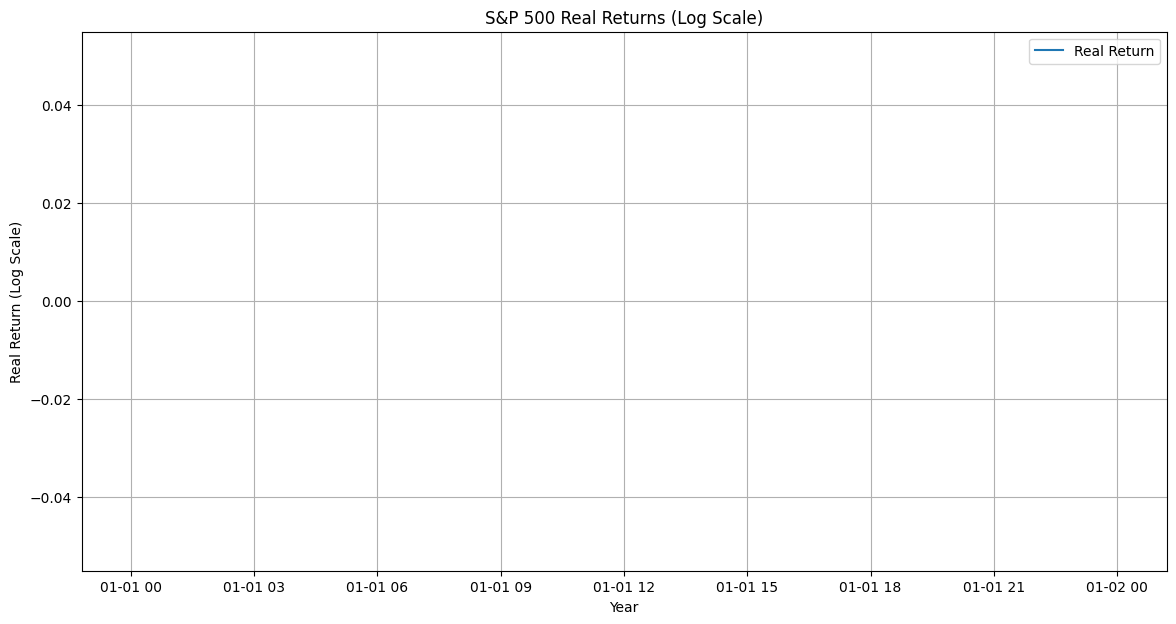

In [14]:
from datetime import datetime

# Convert the date columns to datetime format
sp500_data['Date'] = pd.to_datetime(sp500_data['Date'])
cpi_data['DATE'] = pd.to_datetime(cpi_data['DATE'])

# Since CPI data is monthly, we'll resample the S&P 500 data to monthly as well, using the 'Adj Close' for calculations
# Calculate monthly returns for S&P 500
sp500_monthly = sp500_data.resample('M', on='Date')['Adj Close'].last().pct_change()

# Rename the CPI data columns for consistency and easier merging
cpi_data.rename(columns={'DATE': 'Date', 'CPIAUCSL': 'CPI'}, inplace=True)

# Merge the datasets on the Date column
merged_data = pd.merge(sp500_monthly, cpi_data, left_index=True, right_on='Date', how='inner')

# Calculate the inflation rate from CPI
merged_data['Inflation'] = merged_data['CPI'].pct_change()

# Calculate the real returns by adjusting the S&P 500 returns for inflation
# Real Return = (1 + Nominal Return) / (1 + Inflation Rate) - 1
merged_data['Real Return'] = (1 + merged_data['Adj Close']) / (1 + merged_data['Inflation']) - 1

# Let's plot the real returns on a log scale
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))
plt.plot(merged_data['Date'], merged_data['Real Return'], label='Real Return')
# plt.yscale('log')
plt.title('S&P 500 Real Returns (Log Scale)')
plt.xlabel('Year')
plt.ylabel('Real Return (Log Scale)')
plt.legend()
plt.grid(True)
plt.show()


In [22]:
merged_data

,Adj Close,Date,CPI,Inflation,Real Return


In [15]:
# Convert the S&P 500 data to monthly frequency by taking the last 'Adj Close' of each month
sp500_monthly_adj = sp500_data.set_index('Date').resample('M').last()

# Ensure CPI data is also set to monthly frequency, using the first day of each month as the date
cpi_data.set_index('Date', inplace=True)
cpi_data_monthly = cpi_data.resample('M').first().reset_index()

# Merge the monthly adjusted S&P 500 data with the CPI data on the date index
merged_data_corrected = pd.merge(sp500_monthly_adj.reset_index(), cpi_data_monthly, on='Date', how='inner')

# Calculate the monthly returns for the S&P 500 again
merged_data_corrected['S&P 500 Monthly Return'] = merged_data_corrected['Adj Close'].pct_change()

# Calculate the inflation rate from CPI
merged_data_corrected['Inflation Rate'] = merged_data_corrected['CPI'].pct_change()

# Calculate the real returns
merged_data_corrected['Real Return'] = (1 + merged_data_corrected['S&P 500 Monthly Return']) / (1 + merged_data_corrected['Inflation Rate']) - 1

# Check if the merge was successful this time by examining the merged dataset
merged_data_corrected[['Date', 'S&P 500 Monthly Return', 'Inflation Rate', 'Real Return']].head(), merged_data_corrected.shape


C:\Users\MarcoJohnSodefi\AppData\Local\Temp\ipykernel_8500\1884380683.py:15: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Call ffill before calling pct_change to retain current behavior and silence this warning.
  merged_data_corrected['Inflation Rate'] = merged_data_corrected['CPI'].pct_change()


(        Date  S&P 500 Monthly Return  Inflation Rate  Real Return
 0 2000-08-31                     NaN             NaN          NaN
 1 2000-09-30               -0.016888             NaN          NaN
 2 2000-10-31               -0.031798             NaN          NaN
 3 2000-11-30                0.019630             NaN          NaN
 4 2000-12-31                0.007034             NaN          NaN,
 (270, 11))

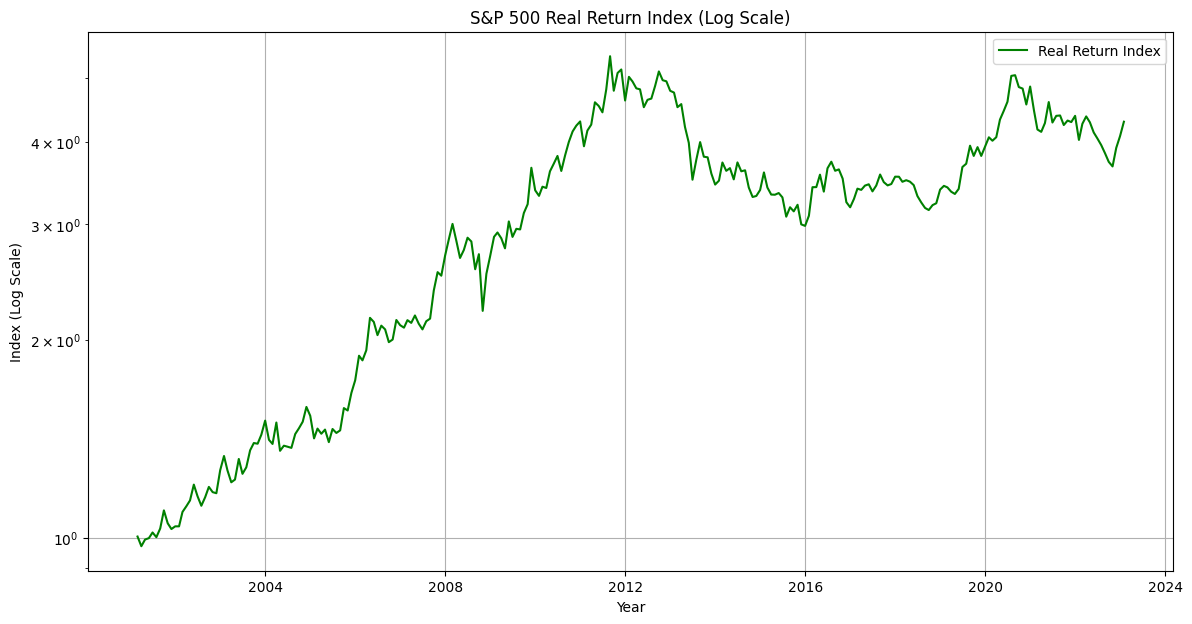

In [16]:
# Calculate the cumulative product of (1 + real returns) to create a real return index
# We drop the first row with NaN values to avoid issues with the cumulative product calculation
merged_data_corrected = merged_data_corrected.dropna(subset=['Real Return'])
merged_data_corrected['Real Return Index'] = (1 + merged_data_corrected['Real Return']).cumprod()

# Plot the real return index on a log scale
plt.figure(figsize=(14, 7))
plt.plot(merged_data_corrected['Date'], merged_data_corrected['Real Return Index'], label='Real Return Index', color='green')
plt.yscale('log')
plt.title('S&P 500 Real Return Index (Log Scale)')
plt.xlabel('Year')
plt.ylabel('Index (Log Scale)')
plt.legend()
plt.grid(True)
plt.show()


In [17]:
merged_data_corrected

,Date,Open,High,Low,Close,Adj Close,Volume,CPI,S&P 500 Monthly Return,Inflation Rate,Real Return,Real Return Index
6,2001-02-28,266.799988,266.799988,266.799988,266.799988,266.799988,0,NaN,0.004518,0.000000,0.004518,1.004518
7,2001-03-31,258.799988,259.299988,256.600006,257.899994,257.899994,2479,NaN,-0.033358,0.000000,-0.033358,0.971009
8,2001-04-30,264.000000,264.000000,264.000000,264.000000,264.000000,0,NaN,0.023653,0.000000,0.023653,0.993976
9,2001-05-31,265.100006,268.100006,264.799988,265.299988,265.299988,1108,NaN,0.004924,0.000000,0.004924,0.998870
10,2001-06-30,270.600006,270.600006,270.600006,270.600006,270.600006,0,NaN,0.019977,0.000000,0.019977,1.018825
...,...,...,...,...,...,...,...,...,...,...,...,...
265,2022-09-30,1661.699951,1672.699951,1658.000000,1662.400024,1662.400024,548,NaN,-0.029426,0.000000,-0.029426,3.732168
266,2022-10-31,1641.800049,1641.800049,1633.400024,1635.900024,1635.900024,522,NaN,-0.015941,0.000000,-0.015941,3.672674
267,2022-11-30,1748.099976,1769.400024,1745.099976,1746.000000,1746.000000,3339,NaN,0.067302,0.000000,0.067302,3.919853
268,2022-12-31,1817.000000,1822.300049,1816.800049,1819.699951,1819.699951,95,NaN,0.042211,0.000000,0.042211,4.085313


In [26]:
import pandas as pd

# Assuming cpi_df and sp500_df are already defined and loaded

# Convert the index of sp500_df to datetime if it's not already
if not isinstance(sp500_df.index, pd.DatetimeIndex):
    sp500_df.index = pd.to_datetime(sp500_df.index,  utc=True)
    
if not isinstance(cpi_df.index, pd.DatetimeIndex):
    cpi_df.index = pd.to_datetime(cpi_df.index,  utc=True)

# Calculate Monthly Inflation Rate
monthly_inflation_rate = cpi_df['CPIAUCSL'].pct_change()

# Prepare CPI data to ensure it aligns with the S&P 500 date range
cpi_df['YearMonth'] = cpi_df.index.to_period('M')

# Ensure sp500_df index is a DatetimeIndex and create a 'YearMonth' column
sp500_df['YearMonth'] = sp500_df.index.to_period('M')

# Merge the monthly inflation rate into the sp500_df DataFrame
monthly_inflation_rate_df = monthly_inflation_rate.reset_index().rename(columns={'CPIAUCSL': 'InflationRate'})
monthly_inflation_rate_df['YearMonth'] = monthly_inflation_rate_df['index'].dt.to_period('M')
sp500_df = sp500_df.merge(monthly_inflation_rate_df[['YearMonth', 'InflationRate']], on='YearMonth', how='left')

# Adjust S&P 500 'Close' Prices by Monthly Inflation Rate
sp500_df['RealCloseFinal'] = sp500_df.apply(lambda row: row['Close'] * (1 + row['InflationRate']), axis=1)

# Clean up the DataFrame by removing the intermediate 'YearMonth' column
sp500_df.drop(columns=['YearMonth', 'InflationRate'], inplace=True)

# Display the adjusted DataFrame
print(sp500_df[['Close', 'RealCloseFinal']].tail())


           Close  RealCloseFinal
465  4193.799805             NaN
466  4567.799805             NaN
467  4769.830078             NaN
468  4845.649902             NaN
469  5070.720215             NaN


C:\Users\MarcoJohnSodefi\AppData\Local\Temp\ipykernel_14084\2545538693.py:16: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  cpi_df['YearMonth'] = cpi_df.index.to_period('M')
C:\Users\MarcoJohnSodefi\AppData\Local\Temp\ipykernel_14084\2545538693.py:19: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  sp500_df['YearMonth'] = sp500_df.index.to_period('M')
C:\Users\MarcoJohnSodefi\AppData\Local\Temp\ipykernel_14084\2545538693.py:23: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  monthly_inflation_rate_df['YearMonth'] = monthly_inflation_rate_df['index'].dt.to_period('M')
